<p align="center">
  <img src="Graphics/Episode IX.png" />
</p>

## (0) Introduction to Robot Motion Planning

### (0.1) Learning Outcomes

In this tutorial, we will cover:
* The basic concepts and algorithms of motion planning for robotics
* How can we solve motion planning problems using exact and grid-based methods?

### (0.2) Disclaimer

This tutorial is heavily based on material from Oren Salzman's excellent Technion course ["Algorithmic Robot Motion Planning"](https://students.technion.ac.il/local/technionsearch/course/236901) (236901). It is taught every winter semester in the Faculty of Computer Science, and I highly recommend it for those of you who are interested in the topics we'll discuss today!

<p align="center">
  <img src="Graphics/MotionPlanning.png" width=500/>
</p>

## (1) Basic Concepts in Robot Motion Planning

Up until now, we've mostly been looking at "high-level" planning (i.e. task planning). One of the main concerns with task planning is that it doesn't take into consideration the geometric constraints of the world in which the robot must act. For example, a task planner might tell a robot to move from one side of a room to the other in order to pick up an apple off a table there - but how does the robot actually know how to move its wheels in order to cross the room, and how does it know how to move the joints of its arm in order to pick up the apple?

This where **motion planning** comes into play. This field of "low-level" planning takes into consider the geometry of the robot's environment in order to find the best way for it to move between two locations or move the joints in its arms (for example).

**Informal Definition of the Motion Planning Problem:** Given a robot and a set of obstacles, plan a collision-free path from a
start position to a goal position.

### (1.1) A *Space* Odyssey

Before we get to the algorithms, we first need to discuss some basic concepts in robotics that will allow us to describe the robot's environment mathematically.
* **Workspace:**  The workspace ($\mathcal{W}\subseteq\mathbb{R}^{n}$) describes the physical environment in which the robot operates.
<p align="center">
  <img src="Graphics/Workspace.png" width=300/>
</p>

* **Configuration Space:** The configuration space ($\mathcal{X}\subseteq\mathbb{R}^{d}$) represents the set of all possible *configurations* of the robot.
    * A configuration is a $d$-dimensional point that uniquely defines the position and orientation of the robot, where $d$ is the number of *degrees of freedom*.
    * The number of degrees of freedom (DOFs) is the minimal set of parameters that spans $\mathcal{X}$.
<p align="center">
  <img src="Graphics/CSpace.png" width=300/>
</p>
 
* **Free Space:** The free space $\mathcal{X}_{free}\subseteq \mathcal{X}$ represents the set of all *collision-free* configurations.

### (1.2) Back to the Definition of the Motion Planning Problem

Now that we have a mathematical description for all of the relevant concepts, we can formally define the motion planning problem as follows:

  **Formal Definition:** Let $R$ be a robot system with $d$ degrees of freedom, moving in a known environment cluttered with obstacles. Given start and target configurations $s$ and $t$ for $R$, decide whether there is a collision-free, continuous path $\gamma : [0, 1] \rightarrow \mathcal{X}_{free}$ such that $\gamma (0) = s$ and  $\gamma(1) = t$ and if so, plan such a motion.

<p align="center">
  <img src="Graphics/Arm.gif" width=500/>
</p>

### (1.3) Evaluation of Motion Planning Algorithms

When we discuss algorithms that can solve the motion planning problem, there are some considerations we will need to make in order to evaluate whether a certain algorithm is better than another, and whether it is actually applicable for our situation:
* Completeness
  * Will the algorithm solve all solvable problems?
  * Will the algorithm return no solution for unsolvable problems?
* Optimality
  * Will the algorithm generate the shortest path / least-cost path (for some cost function)?
* Speed (i.e. efficiency)
  * How long does it take to generate a path for real-world problems?
  * How does the run-time scale with dimensionality of the problem and complexity of models?
  * Is there a quality vs. computation time tradeoff?
* Generality
  * What types of problems can / can't it solve?
* Memory Footprint
  * Can we maintain favorable traits (speed / optimality) while reducing memory footprint, if needed?

### (1.4) Beyond The Course's Scope

We will deal with the most basic version of the motion planning problem, but in the real-world there are many other considerations that we might need to make when dealing with robot motion, for example:
* Moving obstacles
* Multiple robots (multi-agent pathfinding, see figure below)
  * If you'd like to learn more about multi-agent pathfinding, Oren Salzman will be teaching a course on the subject next semester (in English) in the Computer Science Faculty: ["Seminar in Robotics"](https://students.technion.ac.il/local/technionsearch/course/236824) (236824)
* Movable objects
* Uncertainty
  * If you'd like to learn more about planning under uncertainty (i.e. belief-space planning), Vadim Indelman will be teaching a course on the subject next semester (in English) in the Aerospace Faculty: ["Autonomous Navigation and Perception"](https://students.technion.ac.il/local/technionsearch/course/86762) (086762)
* Nonholonomic constraints
  * A *holonomic* robot can control all of its degrees of freedom (for example, a Roomba can control all 3 of its DOF's). A nonholonomic robot, as you can guess, can't control all of its DOF's (think of a basic car, which can't directly move sideways - it needs to turn its wheels and drive forward in order to move in the horizontal direction).
* Dynamic constraints
* Human-Robot Interaction (HRI)

<p align="center">
  <img src="Graphics/MultiAgent.gif" width=400/>
</p>

## (2) Exact Motion Planning Methods

It's natural for us to first ask if we can solve the motion planning problem in an exact, analytical manner. While the answer is yes (and we'll see some examples now), the computational complexity of exact methods (also called geometric methods) often make them prohibitive, especially when it comes to complex workspaces (high dimensionality) and robots with large numbers of DOF's.

There are efficient techniques that solve the problem when the number of DOF's is small (i.e. $\leq 4$), however the problem becomes *PSPACE-hard* (very high complexity) when the number of DOF's and the complexity of the workspace are part of the input. Finding the optimal solution, even in $\mathbb{R}^{3}$, is *NP-hard* (high complexity).

We're not gonna give up that easily, though! For now, we will turn our attention to the basic motion planning problem for a 2D workspace where we have a point robot (i.e. we do not need to consider the actually volume of the robot when we check for collisions with obstacles). For point robots, it holds that $\mathcal{X}=\mathcal{W}$ (the C-space is identical to the workspace). A popular group of exact algorithms involve building discrete *roadmaps* in the free space based on its geometry, which can then be searched efficiently by A*-type pathfinding algorithms. The outline of such algorithms looks as follows:
* We (intelligently) break up the free space ($\mathcal{X}_{free}$) into a set of cells, and we use these cells to construct a graph which contains the start and end position and whose edges do not collide with any obstacles
    * Here, we are reducing the continuous C-space into a discrete roadmap
* We run a shortest-path search algorithm (such as Dijkstra or A* - see TA#3) on this graph in order to determine the shortest collision-free path between the start and goal

We will briefly explore two such methods: **trapezoidal decomposition** and **visibility graphs**.

### (2.2) Trapezoidal Decompisition Algorithm

The *cell decomposition method* is an approach which involves a preliminary phase where we preprocess the environment in order to efficiently represent the free space. One method for doing so is to break up the free space into a set of trapezoids (assuming that our obstacles are all polygons), and this is called the *trapezoidal decompisition algorithm*. Let's do so on the following C-Space, where the obstacles are colored red and the free space is colored white:
<p align="center">
  <img src="Graphics/TrapMap0.png" width=300/>
</p>
We start by extending vertical lines up and down from every single vertex of every obstacle:
<p align="center">
  <img src="Graphics/TrapMap1.png" width=300/>
</p>
Next, we remove all line segments inside the obstacles, as well as all line segments that do not contain any obstacle vertex:
<p align="center">
  <img src="Graphics/TrapMap2.png" width=300/>
</p>

We have now obtained a set of trapezoids that do not collide with any obstacles (called the *trapezoidal map*), which we'll denote $\mathcal{T}(\mathcal{X}_{free})$. Notice that for all trapezoids $T \in \mathcal{T}(\mathcal{X}_{free})$, any line segment contained by $T$ is collision-free (since trapezoids are *convex*). Complexity-wise, the trapezoidal map of a set of $n$ line segments in general positions can be computed in $O(n \cdot log (n))$ expected time.

Once we've built the trapzedoial map, we can build the graph (or roadmap) on which we'll run a pathfinding algorithm to obtain our solution - we'll denote it as $\mathcal{G}$. First, we can add the vertices (nodes) of $\mathcal{G}$:
* For each trapezoid $T \in \mathcal{T}(\mathcal{X}_{free})$, place a vertex in the center of $T$
* For each vertical edge $e \in \mathcal{T}(\mathcal{X}_{free})$, place a vertex in the center of $e$

Then, we can add the vedges of $\mathcal{G}$:
* For each trapezoid $T \in \mathcal{T}(\mathcal{X}_{free})$, connect its center vertex all vertices on its vertical edges
* Each edge is embedded as a straight line segment

Our roadmap will thus look as follows:
<p align="center">
  <img src="Graphics/TrapMap3.png" width=400/>
</p>

The construction of the roadmap $\mathcal{G}$ can be completed in $O(n)$ time. Here, our preprocessing phase is complete - all that's left to do is add the start and end points to the graph, and solve! To add the start/end points, we simply identify the trapezoid $T$ in which they are located, and add an edge connecting the points to the center vertex of that $T$. Finally, we run a pathfinding algorithm on $\mathcal{G}$ in order to obtain the shortest path between the start and the goal point. We can use [Dijkstra's Algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) for this, for example, and this incurs a time complexity of $O(|E|+|V|log|V|)$, where $|V|$ is the number of vertices and $|E|$ is the number of edges in $\mathcal{G}$.
<p align="center">
  <img src="Graphics/TrapMap4.png" width=400/>
</p>

While the trapezoidal decompisition algorithm is *complete*, it is still *not optimal* (as you might've guessed from looking at the figure above). Is there any way to guarantee optimal solutions for our problem here? Yes, and we can do so using **visibility graphs**!

### (2.3) Visibility Graphs

#### (2.3.1) Intuition

First, let's think about what we can say about the shape of optimal paths for a point robot trasnlating through a 2D workspace with known polygonal obstacles. Think of a path as an elastic rubber band, whose endpoints are fixed but whose shape we can alter. What happens when we release the rubber band? How do obstacles affect this behaviour?
<p align="center">
  <img src="Graphics/Rubber.png" width=300/>
</p>

This leads us to the following lemma: any shortest path between the start point $p_{start}$ and the goal point $p_{goal}$ among a set $S$ of disjoint
polygonal obstacles is a polygonal path whose inner vertices are vertices of $S$.

#### (2.3.2) Algorithm

Using the lemma we just described, we can define a new roadmap called a visibility graph $G_{vis}(S)$, whose vertices are vertices of $S$. Two vertices are connected by an edge if they are mutually *visible*, and the segment connecting them is called a *visibility edge*. We can build this visibility graph as follows:
* Consider all vertices of the obstacles. For every such vertex, find all other vertices which are mutually visible to it (i.e. we can draw a straight line between them that doesn't collide with any obstacles), and add an edge connecting those vertices. This is the preprocessing phase, and it can be done in most efficiently $O(n^{2}log(n))$ time using the *rotational sweep method* (the general brute-force method we're describing here requires $O(n^{3})$ time, though).
<p align="center">
  <img src="Graphics/Viz0.png" width=400/>
</p>

* Consider the start and goal points. Add them to the roadmap by connecting them to all mutually visible vertices in $G_{vis}(S)$ as edges.
<p align="center">
  <img src="Graphics/Viz1.png" width=400/>
</p>

* Finally, run a pathfinding algorithm on the roadmap $G_{vis}(S)$ in order to obtain the shortest path between the start and the goal point. If we use Dijkstra, for example, we can rememeber that this will incur a time complexity of $O(|E|+|V|log|V|)$, where $|V|$ is the number of vertices and $|E|$ is the number of edges in $G_{vis}(S)$.
<p align="center">
  <img src="Graphics/Viz2.png" width=400/>
</p>

This method is both *complete* and *optimal* for solving our problem. Hooray!

#### (2.3.3) Code Implementation

Let's take a look at a code implementation of the visibility graph algorithm. The relevant scripts and files can be found inside the `Code` folder. Please run the following command in order to install the necessary libraries:
```
pip install matplotlib shapely heapdict
```

There is also an updated `cogrob_environment.yml` file in the tutorial folder that you can use to update or build the virtual environment with these libraries. To update an existing virtual environment from a `.yml` file, just run the following command in the terminal (in the directory where the file is):
```
conda env update -f cogrob_environment.yml
```

Then we can import the necessary modules and libraries into this notebook:

In [1]:
from VisibilityGraph.Dijkstra import Dijkstra
from VisibilityGraph.VisGraph import Plotter, Create_Visibility_Graph
from shapely.geometry.polygon import Polygon

Next, we'll define the initial position of our robot, the location of the goal, and we'll load our obstacles from a file:

In [2]:
robot = [(10,-4), 0.5] # first element is the robot's initial position, second element is just for plotting
query = (-2,4) # goal location
obstacles = 'VisibilityGraph/obstacles' # file containing obstacle data
    
cspace_obstacles = [] # the c-space and workspace are identical, since we are dealing with a point robot!
with open(obstacles, 'r') as f:
    for line in f.readlines():
        ob_vertices = line.split(' ')
        if ',' not in ob_vertices:
            ob_vertices = ob_vertices[:-1]
        points = [tuple(map(float, t.split(','))) for t in ob_vertices]
        cspace_obstacles.append(Polygon(points))

Let's see how our workspace (and C-space) looks:

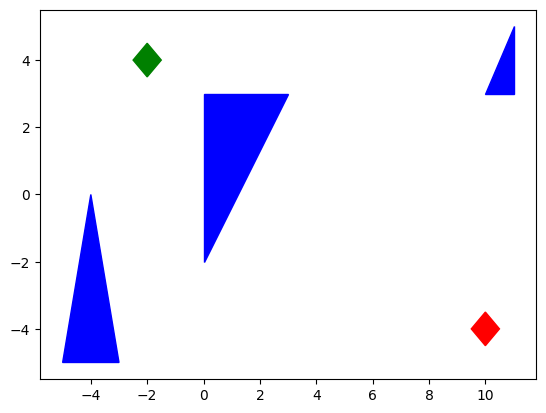

In [3]:
plotter1 = Plotter()
plotter1.add_obstacles(cspace_obstacles)
plotter1.add_robot(robot[0], robot[1])
plotter1.add_goal(query, robot[1])
plotter1.show_graph()

Next, we'll build the initial visibility graph:

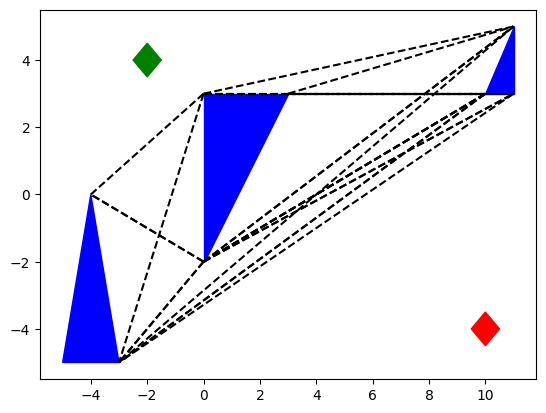

In [4]:
lines = Create_Visibility_Graph(cspace_obstacles)
plotter2 = Plotter()
plotter2.add_obstacles(cspace_obstacles)
plotter2.add_visibility_graph(lines)
plotter2.add_robot(robot[0], robot[1])
plotter2.add_goal(query, robot[1])
plotter2.show_graph()

Finally, we add the start and goal points to the graph, and run the Dijkstra algorithm on it in order to obtain the shortest path:

Dijkstra search completed, shortest path has cost 14.999 and contains 3 nodes.


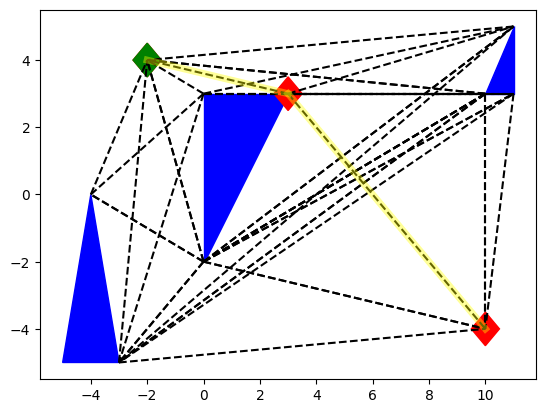

In [5]:
lines = Create_Visibility_Graph(cspace_obstacles, robot[0], query)
shortest_path, cost = Dijkstra(lines, robot[0], query)

plotter3 = Plotter()
plotter3.add_robot(robot[0], robot[1])
plotter3.add_obstacles(cspace_obstacles)
plotter3.add_visibility_graph(lines)
plotter3.add_shortest_path(list(shortest_path))
plotter3.add_goal(query, robot[1])
plotter3.show_graph()

Now that we've looked at some methods for solving the motion planning problem for a point robot traversing a 2D space that contains polygonal obstacles, what can we do if our obstacles are actually not polygons (as is most often the case)? This is where **grid-based** search methods will come in handy!

## (3) Grid-Based Approaches

Before, we decomposed our free space into cells using methods that accounted for the actual geometry of this space. Now, we will discuss a different approach in which we discretize the space of our problem by applying a grid, and then conducting a search over the resulting graph.

In grid-based approaches, we overlay a grid onto the configuration space and assume that each configuration coincides with a grid point. At each grid point, the robot is allowed to move to adjacent grid points as long as the line between them is completely contained within $\mathcal{X}_{free}$ (i.e. collision-free). This discretizes the set of actions, and search algorithms (like A*) are then used to find a path from the start to the goal.

### (3.1) Algorithm

Let's first examine a problem where the obstacles are polygonal. We can place a grid over the C-space such that all obstacle vertices (as well as the start and goal points) coincide with grid vertices:
<p align="center">
  <img src="Graphics/Griddy0.png" width=500/>
</p>

If we remove all vertices from the grid that are contained within obstacles, and remove edges that intersect obstacles, then a search on the remaining graph will yield a path from the start to the goal!
<p align="center">
  <img src="Graphics/Gridd1.png" width=500/>
</p>

### (3.2) Drawbacks

It should be clear that the paths obtained from this method are not optimal if our cost metric is Euclidean distance (though they are optimal if we instead consider Manhattan distance), and this is one of the main disadvantages of this algorithm. We could improve the quality of our paths if we allow the robot to move diagonally, like below:
<p align="center">
  <img src="Graphics/Griddy2.png" width=500/>
</p>
but this still does not produce optimality! What can we say about its completeness, though?

The completeness of this algorithm will depend on the *resolution* of the grid. If our grid has too low a resolution, our search will indeed be very fast but we might run into issues when we have narrow passages that are smaller than this resolution. Consider the following problem:
<p align="center">
  <img src="Graphics/Griddy3.png" width=500/>
</p>

We see that there is no feasible solution when conducting grid search with this resolution (despite the fact that a solution does exist), and so the algorithm is not complete here! To deal with this issue, we should increase the resolution of the grid until it is sufficiently fine in order to find a path through the narrow passage. If we make the resolution too fine, though, our search could take too long!

In order to quantify a necessary lower bound for our resolution, we must first define the notion of a path's *clearance*, which is the minimum distance to any obstacle among all points on the path. Let's look at the clearance of a path (not necessarily the optimal one) in the following C-space:
<p align="center">
  <img src="Graphics/Griddy4.png" width=500/>
</p>

Denoting the clearance to be $d$ and the resolution of the grid to be $h$, it can be shown that if there exists a path with clearance $d\geq \frac{h}{\sqrt{2}}$, then a grid planner with resolution $h$ is guaranteed to find a path. Such a grid might look as follows:
<p align="center">
  <img src="Graphics/Griddy5.png" width=500/>
</p>

Finally, we must note that the number of points on the grid grows exponentially with the number of DOF's, and thus this method quickly becomes very inefficient for high-dimensional problems.

### (3.3) Code Implementation

Let's now take a look at a code implementation of a grid-based search algorithm that relies on A*. The relevant scripts and files can be found inside the `Code` folder. First, we can import the necessary modules and libraries into this notebook:

In [6]:
from GridBasedSearch.GridSearch import AStarPlanner
from GridBasedSearch.MapEnvironment import MapEnvironment

Next, we'll prepare the environement for the problem. The C-space looks as follows, with the start point colored red, the goal point colored green, the obstacles colored yellow, and the free space colored purple:

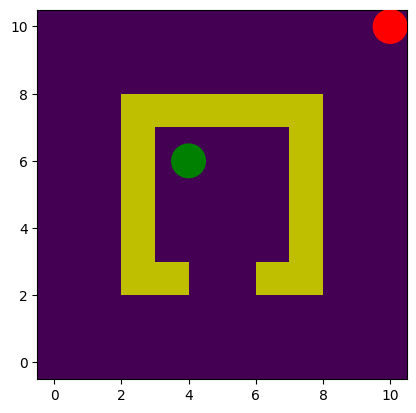

In [7]:
planning_env = MapEnvironment(json_file='GridBasedSearch/map.json')

Then, we can call the A* planner and have it solve the problem:

In [8]:
planner = AStarPlanner(planning_env=planning_env)
plan = planner.plan()

Finally, we can visualize the final path with according to the plan returned by A*:

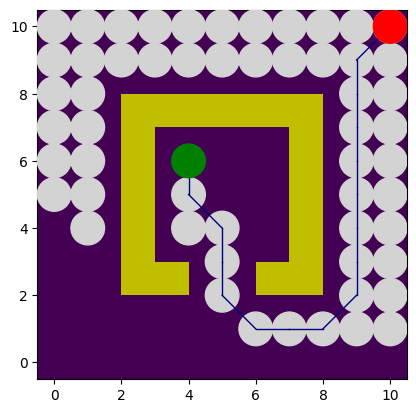

In [9]:
planner.planning_env.visualize_map(plan=plan, expanded_nodes=planner.get_expanded_nodes());

## (4) Conclusion

In this tutorial, we:
* Introduced the motion planning problem and discussed its importance in the field of cognitive robotics
* Discussed the core concepts of motion planning, such as the configuration space
* Covered exact motion planning methods, such as trapezoidal decomposition and visibility graphs
* Introduced grid-based approaches for motion planning

Next week we will continue our discussion on motion planning, and we will introduce a group of algorithms called sampling-based motion planners (such as PRM and RRT). Tentatively, we will also learn how to solve motion planning problems in ROS using MoveIt.

#### ***Credit:** This tutorial was written by Yotam Granov, Winter 2022.*

### **References**

[1] [Graph Search](http://motion.cs.illinois.edu/RoboticSystems/GraphSearch.html)

[2] Jacob Goodman & Joseph O’Rourke. *Handbook of Discrete and Computational Geometry (First Edition)*. CRC Press, 1997.

[3] [Motion Planning in Simple Geometric Spaces](http://motion.cs.illinois.edu/RoboticSystems/GeometricMotionPlanning.html)

[4] Oren Salzman's *"Algorithmic Robot Motion Planning"* Technion Course, 2022.

[5] [Robotic Motion Planning: Cell Decompositions](https://www.cs.cmu.edu/~motionplanning/lecture/Chap6-CellDecomp_howie.pdf)

[6] Steven LaValle. *Planning Algorithms*. Cambridge University Press, 2006.